# Outline of NLP Project

This project is designed to examine tweets created directly by a company's official Twitter account. I utilize tweet content to predict if a company beats the consensus earnings expectation each quarter. This project utilizes stock level data from CRSP and earnings announcemnet data from IBES in addition to the Twitter data. 

The primary challenge with this project is working with the Twitter data to determine if a tweet is considered financial or generic. Once I identify all tweets that are financial in topic, I use various machine learning algorithms to get the likelihood that a tweet is associated with an earnings beat (1) or an earnings miss (0). From this prediction, I retain the probability that a tweet is associated with a beat/miss for use in a 2nd model. This second model utilizes these probabilities as a single feature in the second model, allowing me to incorporate many other stock characteristics into the analysis.

This project focuses on utilizing NLP in the field of finance and/or accounting. Although I do not have a large number of tweets (~1,400), this project is designed more for learning the techniques utilized when working with text than it is to provide a practical application for beating analyst recommendations.

In [1]:
import pandas as pd
import numpy as np
import re

pd.options.display.max_colwidth = 200

I obtain daily stock level data from CRSP and import the data as a stata file.

In [2]:
stock = pd.read_stata('daily_stock.dta')
print(stock.info())
stock.head(5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21097755 entries, 0 to 21097754
Data columns (total 10 columns):
permno      float64
date        datetime64[ns]
shrcd       float64
ticker      object
primexch    object
cusip       object
prc         float64
vol         float64
ret         float64
shrout      float64
dtypes: datetime64[ns](1), float64(6), object(3)
memory usage: 1.7+ GB
None


,permno,date,shrcd,ticker,primexch,cusip,prc,vol,ret,shrout
0,10001.0,2007-01-03,11.0,EWST,Q,36720410,11.100000,4311.0,0.000000,2959.0
1,10001.0,2007-01-04,11.0,EWST,Q,36720410,11.360000,4600.0,0.023423,2959.0
2,10001.0,2007-01-05,11.0,EWST,Q,36720410,11.250000,510.0,-0.009683,2959.0
3,10001.0,2007-01-08,11.0,EWST,Q,36720410,-11.344999,0.0,0.008444,2959.0
4,10001.0,2007-01-09,11.0,EWST,Q,36720410,11.240000,600.0,-0.009255,2959.0


I clean the stock data based on the following characteristics
    - share code = 10,11
    - primary exchange = N, A, or Q
    - absolute value price > 1
    - volumne >= 0
    - returns >= -1, convert B and C to NaN values
    - shares outstanding > 0
    
    - drop all remaining missing observations


In [3]:
stock = stock.loc[(stock['shrcd'] == 10.0 ) | (stock['shrcd'] == 11.0)]
stock = stock.loc[(stock['primexch'] == 'N') | (stock['primexch'] == 'A') | (stock['primexch'] == 'Q')]
stock['price'] = stock['prc'].abs()
stock = stock.loc[(stock['price'] >= 1)]
stock = stock.loc[(stock['vol'] >= 0)]
stock['ret'] = stock['ret'].replace(['B','C'], np.nan).apply(float)
stock = stock.loc[(stock['ret'] >= -1)]
stock = stock.loc[(stock['shrout'] > 0)]

stock['mcap'] = stock['shrout'] * stock['price']

stock.drop(columns = ['cusip','prc','shrcd','primexch','shrout'], inplace = True)
stock = stock.dropna()

stock.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11340601 entries, 0 to 21097754
Data columns (total 7 columns):
permno    float64
date      datetime64[ns]
ticker    object
vol       float64
ret       float64
price     float64
mcap      float64
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 692.2+ MB


I import Twitter data as a stata file. This data is already partially cleaned from a prior project.

In [4]:
tweets = pd.read_stata('Tweets_C2.dta')
print(tweets.info(null_counts=True))
tweets.sample(5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3439754 entries, 0 to 3439753
Data columns (total 7 columns):
twhandle         3439754 non-null object
permno           3439754 non-null int32
tweet_content    3439754 non-null object
timestr          3439754 non-null object
date             3439754 non-null datetime64[ns]
time             3439754 non-null object
tweet_id         3439754 non-null float32
dtypes: datetime64[ns](1), float32(1), int32(1), object(4)
memory usage: 183.7+ MB
None


,twhandle,permno,tweet_content,timestr,date,time,tweet_id
2627058,SERVICENOW,13447,Don't be mistaken for a poser. Avoid this by remembering to wear your conference passes at all times! #NewsYouCanUse #Know14,10:30:02 PM,2014-04-27,,2627059.0
601285,CHIPOTLETWEETS,91068,"@nisa_ariÂ @tortillamaria @LMehalko If you can't enjoy lunch together, at least you can enjoy a burrito together, virtually. -Myra",,2011-10-27,3:29 PM,601286.0
1329542,HOMEAWAY,12882,"@vanessapeters We're sorry to hear you are having difficulty, please email us with your info so we can move it forward social@homeaway.com",8:57:53 PM,2013-04-23,,1329543.0
1243359,GREENMTNCOFFEE,79588,"@CowLoverJF We can't have that now, can we, Elizabeth? ;]",,2013-09-06,1:30 PM,1243360.0
1737556,MACYS,77462,@trangdhuynh We're glad an associate was able to help! What did you end up getting?,,2012-10-22,1:40 PM,1737557.0


For practice working with text, I complete the following steps manually
    - I identify time strings that have a PM attached to it
    - I drop the AM and PM strings
    - I create a variable for hour and minute from the time string
    - I create a new 24 hour variable that adjusts 12 hour clocks based on if there was a PM attached

In [5]:
tweets['PM'] = tweets['timestr'].str.contains(r'\bPM\b',flags=re.IGNORECASE)
tweets.loc[(tweets['timestr'] == ''), ['PM']] = tweets['time'].str.contains(r'\bPM\b',flags=re.IGNORECASE)

tweets['timestr'] = tweets['timestr'].str.replace('PM','')
tweets['timestr'] = tweets['timestr'].str.replace('AM','')
tweets['time'] = tweets['time'].str.replace('PM','')
tweets['time'] = tweets['time'].str.replace('AM','')

tweets.loc[(tweets['time'] == ''), ['time']] = tweets['timestr']
tweets['hour'] = tweets['time'].str.extract(r'([0-9]+)')
tweets['minute'] = tweets['time'].str.extract(r'((?<=\:)[0-9]+)')

tweets[['hour','minute']] = tweets[['hour','minute']].apply(pd.to_numeric)

tweets2 = tweets.copy(deep=True)
tweets2.loc[(tweets2['PM'] == True), ['hour']] = tweets2['hour'] + 11
tweets2['hour'] = tweets2['hour'].apply(str)
tweets2['minute'] = tweets2['minute'].apply(str)
tweets2['hour_24'] = pd.to_datetime(tweets2['hour'] + ':' + tweets2['minute'], format='%H:%M').dt.time

tweets3 = tweets2.drop(columns = ['twhandle','timestr','time','PM','hour','minute']).copy(deep=True)
tweets3.head()

,permno,tweet_content,date,tweet_id,hour_24
0,87162,@AWESOMEDAPHY I'm sorry for the disappointment! We often run contests like this via FB or TW. Keep checking back after your birthday!-Stacey,2014-04-08,1.0,02:52:00
1,87162,@ChitownFelice you should receive it shortly. Is there anything else I can help you with? Sheila,2014-05-06,2.0,12:54:00
2,87162,"@HamptonsMPiece Send me your phone number in a private message, follow us, & we will call you.--PJ",2014-05-17,3.0,15:15:00
3,87162,@monsour I am sorry for the inconvenience. Plz follow and DM me so I can check the status of your order. Thanks! AJ,2014-05-13,4.0,18:58:00
4,87162,"@RemarkablyAvg I am sry we havnt heard back fr u re: the issue u posted. Pls reach out 2 us if u need any assistance, we r here 2 help.Thx!",2014-05-08,5.0,10:57:00


In [6]:
print(stock.info())
print(tweets3[['permno','date']].info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11340601 entries, 0 to 21097754
Data columns (total 7 columns):
permno    float64
date      datetime64[ns]
ticker    object
vol       float64
ret       float64
price     float64
mcap      float64
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 692.2+ MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3439754 entries, 0 to 3439753
Data columns (total 2 columns):
permno    int32
date      datetime64[ns]
dtypes: datetime64[ns](1), int32(1)
memory usage: 65.6 MB
None


I merge the stock data with the Twitter data while requiring information within both files

In [7]:
tweets4 = pd.merge(tweets3, stock, left_on=['permno','date'], right_on=['permno','date'], how = 'inner')
print(tweets4.info())
tweets4['ticker'].nunique()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2734956 entries, 0 to 2734955
Data columns (total 10 columns):
permno           int32
tweet_content    object
date             datetime64[ns]
tweet_id         float32
hour_24          object
ticker           object
vol              float64
ret              float64
price            float64
mcap             float64
dtypes: datetime64[ns](1), float32(1), float64(4), int32(1), object(3)
memory usage: 208.7+ MB
None


1065

I create a function that will allow me to determine if a tweet contains a cashtag of the company creating the tweet

In [8]:
def find_ticker(text,ticker):
    x = '$'+ticker
    if x.lower() in text.lower():
        return True
    else:
        return False

In [9]:
tweets4['cashtag_tweet'] = tweets4.apply(lambda y: find_ticker(y['tweet_content'],y['ticker']),axis=1)
tweets4['cashtag_tweet'].value_counts()

False    2724359
True       10597
Name: cashtag_tweet, dtype: int64

I identify all tweets that are considered financial by the following list of words
    - earning
    - conference call
    - revenue
    - quarterly
    - CEO
    - CFO
    - financial
    - finance
    - fiscal

In [10]:
tweets4['fin_tweet'] = tweets4['tweet_content'].str.contains \
    (r'\bearning|conference call|revenue|quarterly|CEO|CFO|financial|finance|fiscal' \
     ,flags=re.IGNORECASE)
tweets4['fin_tweet'].value_counts()

False    2685165
True       49791
Name: fin_tweet, dtype: int64

I identify all tweets that contain a URL link

In [11]:
tweets4['url_tweet'] = tweets4['tweet_content'].str.contains(r'http')
tweets4['url_tweet'].value_counts()

True     1655686
False    1079270
Name: url_tweet, dtype: int64

I create a new set of variables based on the classifications above
    - financial_tweet = financial words + cashtags
    - financial_url = financial_tweet + url_tweet

In [12]:
tweets5 = tweets4.copy(deep=True)

tweets5['financial_tweet'] = (tweets5['fin_tweet'] | tweets5['cashtag_tweet']).astype(int)
tweets5['financial_url'] = (tweets5['financial_tweet'] & tweets5['url_tweet']).astype(int)
tweets5[['cashtag_tweet','fin_tweet','url_tweet']] = tweets5[['cashtag_tweet','fin_tweet','url_tweet']].astype(int)

print(tweets5['financial_tweet'].value_counts())
print(tweets5['financial_url'].value_counts())

tweets5.drop(columns=['url_tweet','tweet_id'], inplace=True)

tweets5['actual_dt_t'] = pd.to_datetime(tweets5['date'].apply(str) + ' ' + tweets5['hour_24'].apply(str))

tweets5.head()

0    2678100
1      56856
Name: financial_tweet, dtype: int64
0    2690079
1      44877
Name: financial_url, dtype: int64


,permno,tweet_content,date,hour_24,ticker,vol,ret,price,mcap,cashtag_tweet,fin_tweet,financial_tweet,financial_url,actual_dt_t
0,87162,@AWESOMEDAPHY I'm sorry for the disappointment! We often run contests like this via FB or TW. Keep checking back after your birthday!-Stacey,2014-04-08,02:52:00,FLWS,107325.0,0.012963,5.47,149790.474255,0,0,0,0,2014-04-08 02:52:00
1,87162,@glehel We are following you please DM us your order details. Ty Erika,2014-04-08,01:35:00,FLWS,107325.0,0.012963,5.47,149790.474255,0,0,0,0,2014-04-08 01:35:00
2,87162,@matthewdworkman I'm very sorry to hear about your frustration. Plz follow and DM me. I will be happy to help you. Thanks! - Janet,2014-04-08,16:52:00,FLWS,107325.0,0.012963,5.47,149790.474255,0,0,0,0,2014-04-08 16:52:00
3,87162,@Kusand I am very sorry this. If I can assist with anything please DM me. - Janet,2014-04-08,20:04:00,FLWS,107325.0,0.012963,5.47,149790.474255,0,0,0,0,2014-04-08 20:04:00
4,87162,We've extended the Midnight Red's Roses #Sweepstakes! Enter to be one of the FIVE winners: http://t.co/pry4KGaZm0 @ItsMidnightRed,2014-04-08,16:29:00,FLWS,107325.0,0.012963,5.47,149790.474255,0,0,0,0,2014-04-08 16:29:00


Obtain earnings data from IBES

In [13]:
ibes = pd.read_stata('ibes_full.dta')
ibes.drop(columns = ['ticker','measure','fpi'], inplace=True)
ibes.dropna(inplace=True)
print(ibes.info())
ibes.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1143331 entries, 0 to 1444462
Data columns (total 10 columns):
cusip          1143331 non-null object
oftic          1143331 non-null object
cname          1143331 non-null object
numest         1143331 non-null float64
meanest        1143331 non-null float64
stdev          1143331 non-null float64
fpedats        1143331 non-null datetime64[ns]
actual         1143331 non-null float64
anndats_act    1143331 non-null datetime64[ns]
anntims_act    1143331 non-null object
dtypes: datetime64[ns](2), float64(4), object(4)
memory usage: 96.0+ MB
None


,cusip,oftic,cname,numest,meanest,stdev,fpedats,actual,anndats_act,anntims_act
0,87482X10,TLMR,TALMER BANCORP,4.0,0.08,0.01,2014-03-31,0.12,2014-05-06,10:45:00
1,87482X10,TLMR,TALMER BANCORP,5.0,0.13,0.01,2014-06-30,0.27,2014-08-06,17:05:00
2,87482X10,TLMR,TALMER BANCORP,5.0,0.13,0.01,2014-06-30,0.27,2014-08-06,17:05:00
3,87482X10,TLMR,TALMER BANCORP,5.0,0.13,0.01,2014-06-30,0.27,2014-08-06,17:05:00
4,87482X10,TLMR,TALMER BANCORP,5.0,0.25,0.05,2014-09-30,0.26,2014-11-04,16:15:00


I retain only the most recent observation for each company*earnings observation

From the most recent observations, I calculate the following variables
    - eps_surprise as the acutal earnings result - the expected earnings result
    - eps_beat as a 1/0 if eps_surprise is positive
    - earn_date as the actual date an earnings announcement occurs
        - if an announcement occurs after 4:00pm, I assign the announcement date to the next day

In [14]:
from datetime import datetime, timedelta

earn = ibes.groupby(['oftic','anndats_act'],as_index=False).last()

earn['eps_surprise'] = earn['actual'] - earn['meanest']
earn['eps_beat'] = np.where(earn['eps_surprise'] > 0, 1, 0)
    
earn['earn_date'] = earn['anndats_act']
earn.loc[(earn['anntims_act'] >= '14:00'), ['earn_date']] = earn['anndats_act'] + timedelta(days=1)

earn['actual_dt_e'] = pd.to_datetime(earn['anndats_act'].apply(str) + ' ' + earn['anntims_act'].apply(str))

earn.drop(columns = ['meanest','actual','fpedats','cusip','cname','anndats_act','anntims_act'], inplace=True)
earn[earn['oftic'] == 'AAPL'].sample(5)

,oftic,numest,stdev,eps_surprise,eps_beat,earn_date,actual_dt_e
428,AAPL,47.0,0.07,-0.0214,0,2012-10-26,2012-10-25 16:30:00
433,AAPL,46.0,0.05,0.0614,1,2014-01-28,2014-01-27 16:30:00
443,AAPL,37.0,0.04,0.0400,1,2016-07-27,2016-07-26 16:30:00
411,AAPL,27.0,0.01,0.0200,1,2008-07-22,2008-07-21 16:30:00
439,AAPL,39.0,0.10,0.0500,1,2015-07-22,2015-07-21 16:30:00


In [15]:
print(earn.info())
print(tweets5.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 199960 entries, 0 to 199959
Data columns (total 7 columns):
oftic           199960 non-null object
numest          199960 non-null float64
stdev           199960 non-null float64
eps_surprise    199960 non-null float64
eps_beat        199960 non-null int32
earn_date       199960 non-null datetime64[ns]
actual_dt_e     199960 non-null datetime64[ns]
dtypes: datetime64[ns](2), float64(3), int32(1), object(1)
memory usage: 16.4+ MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2734956 entries, 0 to 2734955
Data columns (total 14 columns):
permno             int32
tweet_content      object
date               datetime64[ns]
hour_24            object
ticker             object
vol                float64
ret                float64
price              float64
mcap               float64
cashtag_tweet      int32
fin_tweet          int32
financial_tweet    int32
financial_url      int32
actual_dt_t        datetime64[ns]
dtypes: datetime64[n

I combine my Twitter data with IBES data where I want to keep all Tweets that occur over the earnings period (t-1, t=0), or the announcement date and the day prior.

In [16]:
# combine earnings data with twitter/stock data to identify which dates are earnings dates

full_sample = pd.merge_asof(tweets5.set_index('date').sort_index(), \
                            earn.set_index('earn_date',drop=False).sort_index(), \
                            left_by = ['ticker'], \
                            right_by = ['oftic'], \
                            left_index = True, \
                            right_index = True, \
                            tolerance = pd.Timedelta(days=1), \
                            direction = 'forward', \
                            )

full_sample2 = full_sample.dropna()
full_sample2.reset_index(inplace=True)
print(full_sample2.info())
full_sample2.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87745 entries, 0 to 87744
Data columns (total 21 columns):
date               87745 non-null datetime64[ns]
permno             87745 non-null int32
tweet_content      87745 non-null object
hour_24            87745 non-null object
ticker             87745 non-null object
vol                87745 non-null float64
ret                87745 non-null float64
price              87745 non-null float64
mcap               87745 non-null float64
cashtag_tweet      87745 non-null int32
fin_tweet          87745 non-null int32
financial_tweet    87745 non-null int32
financial_url      87745 non-null int32
actual_dt_t        87745 non-null datetime64[ns]
oftic              87745 non-null object
numest             87745 non-null float64
stdev              87745 non-null float64
eps_surprise       87745 non-null float64
eps_beat           87745 non-null float64
earn_date          87745 non-null datetime64[ns]
actual_dt_e        87745 non-null datetime64

,date,permno,tweet_content,hour_24,ticker,vol,ret,price,mcap,cashtag_tweet,...,financial_tweet,financial_url,actual_dt_t,oftic,numest,stdev,eps_surprise,eps_beat,earn_date,actual_dt_e
0,2007-07-24,47466,President Again Seeks to Link Qaeda of Iraq to Qaeda of 9/11 http://tinyurl.com/2clvtr,18:09:00,NYT,857400.0,-0.000430,23.219999,3.322341e+06,0,...,0,0,2007-07-24 18:09:00,NYT,10.0,0.03,-0.02,0.0,2007-07-25,2007-07-25 08:35:00
1,2007-07-24,47466,Libya Frees Foreign Medical Workers in H.I.V. Case http://tinyurl.com/2b6gz5,06:19:00,NYT,857400.0,-0.000430,23.219999,3.322341e+06,0,...,0,0,2007-07-24 06:19:00,NYT,10.0,0.03,-0.02,0.0,2007-07-25,2007-07-25 08:35:00
2,2007-07-24,84788,$11.99 - Weeds - Season One http://amazon.com/goldbox,12:00:00,AMZN,26366479.0,-0.034709,69.250000,2.862788e+07,0,...,0,0,2007-07-24 12:00:00,AMZN,21.0,0.03,0.04,1.0,2007-07-25,2007-07-24 16:01:00
3,2007-07-24,47466,Blair Sees âSense of Possibilityâ in Mideast Talks http://tinyurl.com/2abfkw,09:08:00,NYT,857400.0,-0.000430,23.219999,3.322341e+06,0,...,0,0,2007-07-24 09:08:00,NYT,10.0,0.03,-0.02,0.0,2007-07-25,2007-07-25 08:35:00
4,2007-07-24,47466,Libyaâs Release of 6 Prisoners Raises Criticism http://tinyurl.com/264akg,18:18:00,NYT,857400.0,-0.000430,23.219999,3.322341e+06,0,...,0,0,2007-07-24 18:18:00,NYT,10.0,0.03,-0.02,0.0,2007-07-25,2007-07-25 08:35:00


I finalize my Twitter sample by removing all Tweets that occur on the same day as an earnings announcement but that occur after the actual time of the announcement. This results in a final sample that contains only tweets that occur on or before an earnings announcement.

In [17]:
full_sample3 = full_sample2.loc[(full_sample2['actual_dt_e'] > full_sample2['actual_dt_t'])]

print(full_sample3.info())
print(full_sample3['financial_tweet'].value_counts())
print(full_sample3['ticker'].nunique())
full_sample3.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33393 entries, 0 to 87744
Data columns (total 21 columns):
date               33393 non-null datetime64[ns]
permno             33393 non-null int32
tweet_content      33393 non-null object
hour_24            33393 non-null object
ticker             33393 non-null object
vol                33393 non-null float64
ret                33393 non-null float64
price              33393 non-null float64
mcap               33393 non-null float64
cashtag_tweet      33393 non-null int32
fin_tweet          33393 non-null int32
financial_tweet    33393 non-null int32
financial_url      33393 non-null int32
actual_dt_t        33393 non-null datetime64[ns]
oftic              33393 non-null object
numest             33393 non-null float64
stdev              33393 non-null float64
eps_surprise       33393 non-null float64
eps_beat           33393 non-null float64
earn_date          33393 non-null datetime64[ns]
actual_dt_e        33393 non-null datetime64

,date,permno,tweet_content,hour_24,ticker,vol,ret,price,mcap,cashtag_tweet,...,financial_tweet,financial_url,actual_dt_t,oftic,numest,stdev,eps_surprise,eps_beat,earn_date,actual_dt_e
0,2007-07-24,47466,President Again Seeks to Link Qaeda of Iraq to Qaeda of 9/11 http://tinyurl.com/2clvtr,18:09:00,NYT,857400.0,-0.000430,23.219999,3.322341e+06,0,...,0,0,2007-07-24 18:09:00,NYT,10.0,0.03,-0.02,0.0,2007-07-25,2007-07-25 08:35:00
1,2007-07-24,47466,Libya Frees Foreign Medical Workers in H.I.V. Case http://tinyurl.com/2b6gz5,06:19:00,NYT,857400.0,-0.000430,23.219999,3.322341e+06,0,...,0,0,2007-07-24 06:19:00,NYT,10.0,0.03,-0.02,0.0,2007-07-25,2007-07-25 08:35:00
2,2007-07-24,84788,$11.99 - Weeds - Season One http://amazon.com/goldbox,12:00:00,AMZN,26366479.0,-0.034709,69.250000,2.862788e+07,0,...,0,0,2007-07-24 12:00:00,AMZN,21.0,0.03,0.04,1.0,2007-07-25,2007-07-24 16:01:00
3,2007-07-24,47466,Blair Sees âSense of Possibilityâ in Mideast Talks http://tinyurl.com/2abfkw,09:08:00,NYT,857400.0,-0.000430,23.219999,3.322341e+06,0,...,0,0,2007-07-24 09:08:00,NYT,10.0,0.03,-0.02,0.0,2007-07-25,2007-07-25 08:35:00
4,2007-07-24,47466,Libyaâs Release of 6 Prisoners Raises Criticism http://tinyurl.com/264akg,18:18:00,NYT,857400.0,-0.000430,23.219999,3.322341e+06,0,...,0,0,2007-07-24 18:18:00,NYT,10.0,0.03,-0.02,0.0,2007-07-25,2007-07-25 08:35:00


I now proceed with the text cleaning. By waiting until a final sample is complete, I minimize the time it takes to work with the text. I first remove RT indicating a tweet is actually a retweet, I remove url links, I remove the # for hashtags, I remove cashtags, and I remove user IDs. 

In [18]:
import string

full_sample4 = full_sample3.copy(deep=True)

full_sample4['tweet_content'] = full_sample4['tweet_content'].str.replace \
(r'(^rt\s?|http?\S+\s?|\#\s?|(\$[a-z0-9]+\s?)|\@[a-z0-9]+\s?)','',case=False).str.strip()
full_sample4['tweet_content'] = full_sample4['tweet_content'].str.replace(r'(\s?\s+)',' ')

full_sample4['tweet_content'][0] = "Y'all can't expand cause contractions I'd think"
full_sample4['tweet_content'][0]

C:\Users\jstar\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


"Y'all can't expand cause contractions I'd think"

I now finalize preprocessing my text data for analysis with the following steps
    - I remove accented characters
    - I expland contractions such as the above I'm
    - I remove special characters that may still remain
    - I lemmative my text
    - I remove stop words

In [19]:
import spacy
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
import unicodedata
import en_core_web_sm

nlp = en_core_web_sm.load(parse=True, tag=True, entity=True)

In [20]:
tokenizer = ToktokTokenizer()

stopword_list = nltk.corpus.stopwords.words('english')
stopword_list.remove('no')
stopword_list.remove('not')

def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

remove_stopwords("The, and, if are stopwords, computer is not")

', , stopwords , computer not'

In [21]:
import contractions

contractions.fix("Y'all can't expand contractions I'd think yall cause you're not smart")

'you all cannot expand contractions I would think you all because you are not smart'

In [22]:
def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD',text).encode('ascii','ignore').decode('utf-8','ignore')
    return text

remove_accented_chars('Sómě Áccěntěd těxt')

'Some Accented text'

In [23]:
def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-Z0-9\s]' if not remove_digits else r'[^a-zA-Z\s]'
    text = re.sub(pattern, '', text)
    return text

remove_special_characters("Well this was fun! What do you think? 123#@!", 
                          remove_digits=True)

'Well this was fun What do you think '

In [24]:
def lemmatize_text(text):
    text = nlp(text)
    text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return text

lemmatize_text("My system keeps crashing! his crashed yesterday, ours crashes daily")

'My system keep crash ! his crashed yesterday , ours crash daily'

In [25]:
def normalize_corpus(corpus, contraction_expansion=True,
                     accented_char_removal=True, text_lower_case=True, 
                     text_lemmatization=True, special_char_removal=True, 
                     stopword_removal=True, remove_digits=True):
    
    normalized_corpus = []
    # normalize each document in the corpus
    for doc in corpus:
        # remove accented characters
        if accented_char_removal:
            doc = remove_accented_chars(doc)
        # expand contractions    
        if contraction_expansion:
            doc = contractions.fix(doc)
        # lowercase the text    
        if text_lower_case:
            doc = doc.lower()
        # remove extra newlines
        doc = re.sub(r'[\r|\n|\r\n]+', ' ',doc)
        # lemmatize text
        if text_lemmatization:
            doc = lemmatize_text(doc)
        # remove special characters and\or digits    
        if special_char_removal:
            # insert spaces between special characters to isolate them    
            special_char_pattern = re.compile(r'([{.(-)!}])')
            doc = special_char_pattern.sub(" \\1 ", doc)
            doc = remove_special_characters(doc, remove_digits=remove_digits)  
        # remove extra whitespace
        doc = re.sub(' +', ' ', doc)
        # remove stopwords
        if stopword_removal:
            doc = remove_stopwords(doc, is_lower_case=text_lower_case)
            
        normalized_corpus.append(doc)
        
    return normalized_corpus

In [26]:
full_sample4['clean_text'] = normalize_corpus(full_sample4['tweet_content'])

full_sample4.iloc[7][['tweet_content', 'clean_text']]

tweet_content    Home Lenderâs Woes Fuel Marketâs Decline
clean_text              home lendera woe fuel marketa decline
Name: 7, dtype: object

In [27]:
final_sample = full_sample4.copy(deep=True)
final_sample = final_sample.loc[final_sample['financial_tweet'] == 1]
final_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1410 entries, 382 to 87511
Data columns (total 22 columns):
date               1410 non-null datetime64[ns]
permno             1410 non-null int32
tweet_content      1410 non-null object
hour_24            1410 non-null object
ticker             1410 non-null object
vol                1410 non-null float64
ret                1410 non-null float64
price              1410 non-null float64
mcap               1410 non-null float64
cashtag_tweet      1410 non-null int32
fin_tweet          1410 non-null int32
financial_tweet    1410 non-null int32
financial_url      1410 non-null int32
actual_dt_t        1410 non-null datetime64[ns]
oftic              1410 non-null object
numest             1410 non-null float64
stdev              1410 non-null float64
eps_surprise       1410 non-null float64
eps_beat           1410 non-null float64
earn_date          1410 non-null datetime64[ns]
actual_dt_e        1410 non-null datetime64[ns]
clean_text     

Start with the machine learning and NLP analyses

In [28]:
from sklearn.model_selection import train_test_split

X = final_sample[['vol','ret','price','mcap','cashtag_tweet','fin_tweet','financial_tweet', \
                              'financial_url','numest','stdev','clean_text','ticker','actual_dt_e']]
y = final_sample['eps_beat']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .4, random_state = 321) 

y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

X_train_text = pd.DataFrame(X_train['clean_text']).reset_index(drop=True)
X_test_text = pd.DataFrame(X_test['clean_text']).reset_index(drop=True)

X_train_meta = X_train.drop(columns = 'clean_text').reset_index(drop=True)
X_test_meta = X_test.drop(columns = 'clean_text').reset_index(drop=True)

X_train_text.shape, y_train.shape, X_test_text.shape, y_test.shape, 

((846, 1), (846,), (564, 1), (564,))

Create a few new variables (based on the cleaned text - may want to consider doing this before preprocessing text too) to determine if tweet characteristics improve model predictions

In [29]:
import string

X_train_meta['char_count'] = X_train_text['clean_text'].apply(len)
X_train_meta['word_count'] = X_train_text['clean_text'].apply(lambda x: len(x.split()))
X_train_meta['word_density'] = X_train_meta['char_count'] / X_train_meta['word_count']

X_test_meta['char_count'] = X_test_text['clean_text'].apply(len)
X_test_meta['word_count'] = X_test_text['clean_text'].apply(lambda x: len(x.split()))
X_test_meta['word_density'] = X_test_meta['char_count'] / X_test_meta['word_count']

Start with a basic count vectorizer with single words to begin with textual analysis

In [30]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(min_df=0., max_df=1., ngram_range=(1,4))

X_train_text_cv = pd.DataFrame(cv.fit_transform(X_train_text['clean_text']).toarray())

X_test_text_cv = pd.DataFrame(cv.transform(X_test_text['clean_text']).toarray())


X_train_full = pd.concat([X_train_text_cv, X_train_meta], axis=1)
X_test_full = pd.concat([X_test_text_cv, X_test_meta], axis=1)

X_train_full.drop(columns = ['mcap','cashtag_tweet','fin_tweet','financial_tweet','ret','vol','price','numest','stdev'], inplace=True)
X_test_full.drop(columns = ['mcap','cashtag_tweet','fin_tweet','financial_tweet','ret','vol','price','numest','stdev'], inplace=True)

In [31]:
import sklearn.naive_bayes
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

grid_params = {'alpha':[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]}

mnb = sklearn.naive_bayes.MultinomialNB()

cv_mnb = GridSearchCV(mnb, grid_params, cv = 5)

cv_mnb.fit(X_train_text_cv,y_train)

print('Grid scores for all models based on CV:\n')
means = cv_mnb.cv_results_['mean_test_score']
stds = cv_mnb.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, cv_mnb.cv_results_['params']):
    print("%0.5f (+/-%0.05f) for %r" % (mean, std * 2, params))
    
print('\nBest parameters set found on train:', cv_mnb.best_params_)
print('\nBest model validation accuracy:', cv_mnb.best_score_)

best_model = cv_mnb.best_estimator_

X_prob_train = pd.DataFrame(best_model.predict_proba(X_train_text_cv)[:,1], columns=['probability'])
X_prob_test = pd.DataFrame(best_model.predict_proba(X_test_text_cv)[:,1], columns=['probability'])

Grid scores for all models based on CV:

0.48818 (+/-0.03597) for {'alpha': 1}
0.56974 (+/-0.02591) for {'alpha': 2}
0.59102 (+/-0.04897) for {'alpha': 3}
0.60757 (+/-0.05150) for {'alpha': 4}
0.64184 (+/-0.05861) for {'alpha': 5}
0.65366 (+/-0.05141) for {'alpha': 6}
0.67139 (+/-0.04688) for {'alpha': 7}
0.68558 (+/-0.04133) for {'alpha': 8}
0.69031 (+/-0.02418) for {'alpha': 9}
0.69031 (+/-0.03663) for {'alpha': 10}
0.69504 (+/-0.02298) for {'alpha': 11}
0.69976 (+/-0.02739) for {'alpha': 12}
0.69504 (+/-0.02301) for {'alpha': 13}
0.69267 (+/-0.03118) for {'alpha': 14}
0.69267 (+/-0.02975) for {'alpha': 15}

Best parameters set found on train: {'alpha': 12}

Best model validation accuracy: 0.6997635933806147


In [32]:
X_train_meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 846 entries, 0 to 845
Data columns (total 15 columns):
vol                846 non-null float64
ret                846 non-null float64
price              846 non-null float64
mcap               846 non-null float64
cashtag_tweet      846 non-null int32
fin_tweet          846 non-null int32
financial_tweet    846 non-null int32
financial_url      846 non-null int32
numest             846 non-null float64
stdev              846 non-null float64
ticker             846 non-null object
actual_dt_e        846 non-null datetime64[ns]
char_count         846 non-null int64
word_count         846 non-null int64
word_density       846 non-null float64
dtypes: datetime64[ns](1), float64(7), int32(4), int64(2), object(1)
memory usage: 86.0+ KB


In [33]:
X_train_meta2 = pd.concat([X_prob_train, X_train_meta,y_train], axis=1)
X_model_2_train = X_train_meta2.groupby(['ticker','actual_dt_e'], as_index=False).agg({'probability':'mean','cashtag_tweet':'mean', \
                                                                                'financial_url':'mean', 'numest':'max', \
                                                                                'char_count':'mean', 'word_count':'mean', \
                                                                                'word_density':'mean','eps_beat':'max'})
y_model_2_train = X_model_2_train['eps_beat']
X_model_2_train = X_model_2_train.drop(columns=['eps_beat','actual_dt_e','ticker'])


X_test_meta2 = pd.concat([X_prob_test, X_test_meta,y_test], axis=1)
X_model_2_test = X_test_meta2.groupby(['ticker','actual_dt_e'], as_index=False).agg({'probability':'mean','cashtag_tweet':'mean', \
                                                                                'financial_url':'mean', 'numest':'max', \
                                                                                'char_count':'mean', 'word_count':'mean', \
                                                                                'word_density':'mean','eps_beat':'max'})
y_model_2_test = X_model_2_test['eps_beat']
X_model_2_test = X_model_2_test.drop(columns=['eps_beat','actual_dt_e','ticker'])


In [34]:
X_model_2_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 565 entries, 0 to 564
Data columns (total 7 columns):
probability      565 non-null float64
cashtag_tweet    565 non-null float64
financial_url    565 non-null float64
numest           565 non-null float64
char_count       565 non-null float64
word_count       565 non-null float64
word_density     565 non-null float64
dtypes: float64(7)
memory usage: 35.3 KB


In [35]:
grid_params = {'alpha':[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]}

mnb = sklearn.naive_bayes.MultinomialNB()

cv_mnb = GridSearchCV(mnb, grid_params, cv = 5)

cv_mnb.fit(X_model_2_train, y_model_2_train)

print('Grid scores for all models based on CV:\n')
means = cv_mnb.cv_results_['mean_test_score']
stds = cv_mnb.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, cv_mnb.cv_results_['params']):
    print("%0.5f (+/-%0.05f) for %r" % (mean, std * 2, params))
    
print('\nBest parameters set found on train:', cv_mnb.best_params_)
print('\nBest model validation accuracy:', cv_mnb.best_score_)

best_model = cv_mnb.best_estimator_

prediction_mnb = best_model.predict(X_model_2_test)
y_prob = best_model.predict_proba(X_model_2_test)

print(best_model.score(X_model_2_test, y_model_2_test))
print(classification_report(y_model_2_test, prediction_mnb))
print(confusion_matrix(y_model_2_test, prediction_mnb))

Grid scores for all models based on CV:

0.66903 (+/-0.13178) for {'alpha': 1}
0.66903 (+/-0.13178) for {'alpha': 2}
0.66903 (+/-0.13178) for {'alpha': 3}
0.67080 (+/-0.13498) for {'alpha': 4}
0.67080 (+/-0.13498) for {'alpha': 5}
0.67257 (+/-0.13197) for {'alpha': 6}
0.67257 (+/-0.13197) for {'alpha': 7}
0.66903 (+/-0.12987) for {'alpha': 8}
0.66726 (+/-0.13320) for {'alpha': 9}
0.66903 (+/-0.13691) for {'alpha': 10}
0.66903 (+/-0.13691) for {'alpha': 11}
0.66726 (+/-0.14053) for {'alpha': 12}
0.66549 (+/-0.12783) for {'alpha': 13}
0.66372 (+/-0.12364) for {'alpha': 14}
0.66549 (+/-0.12832) for {'alpha': 15}

Best parameters set found on train: {'alpha': 6}

Best model validation accuracy: 0.672566371681416
0.6307692307692307
              precision    recall  f1-score   support

         0.0       0.35      0.20      0.25       123
         1.0       0.69      0.83      0.76       267

   micro avg       0.63      0.63      0.63       390
   macro avg       0.52      0.51      0.50  

Grid scores for all models based on CV:

0.32743 (+/-0.00000) for {'C': 0.0001, 'class_weight': 'balanced', 'max_iter': 10000, 'penalty': 'l1', 'solver': 'liblinear'}
0.67257 (+/-0.00000) for {'C': 0.0001, 'class_weight': 'balanced', 'max_iter': 10000, 'penalty': 'l1', 'solver': 'saga'}
0.53805 (+/-0.13498) for {'C': 0.0001, 'class_weight': 'balanced', 'max_iter': 10000, 'penalty': 'l2', 'solver': 'liblinear'}
0.53805 (+/-0.13498) for {'C': 0.0001, 'class_weight': 'balanced', 'max_iter': 10000, 'penalty': 'l2', 'solver': 'saga'}
0.32743 (+/-0.00000) for {'C': 0.0001, 'class_weight': None, 'max_iter': 10000, 'penalty': 'l1', 'solver': 'liblinear'}
0.67257 (+/-0.00000) for {'C': 0.0001, 'class_weight': None, 'max_iter': 10000, 'penalty': 'l1', 'solver': 'saga'}
0.67257 (+/-0.00000) for {'C': 0.0001, 'class_weight': None, 'max_iter': 10000, 'penalty': 'l2', 'solver': 'liblinear'}
0.67257 (+/-0.00000) for {'C': 0.0001, 'class_weight': None, 'max_iter': 10000, 'penalty': 'l2', 'solver': 'sa

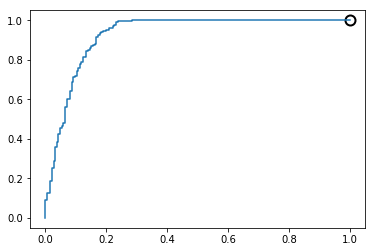

In [36]:
from sklearn.linear_model import LogisticRegression

grid_params = {'penalty':['l1','l2'], 'C':[0.0001, 0.001, 0.01, 0.1, 0.5, 0.75, 0.99, 2, 5], 'solver':['liblinear','saga'], \
              'max_iter':[10000], 'class_weight':['balanced',None]}

lr = LogisticRegression()

cv_lr = GridSearchCV(lr, grid_params, cv = 5)

cv_lr.fit(X_model_2_train,y_model_2_train)

print('Grid scores for all models based on CV:\n')
means = cv_lr.cv_results_['mean_test_score']
stds = cv_lr.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, cv_lr.cv_results_['params']):
    print("%0.5f (+/-%0.05f) for %r" % (mean, std * 2, params))
    
print('\nBest parameters set found on train:', cv_lr.best_params_)
print('\nBest model validation accuracy:', cv_lr.best_score_)

best_model = cv_lr.best_estimator_

y_lr = best_model.predict_proba(X_model_2_train)

fpr, tpr, thresholds = roc_curve(y_model_2_train, y_lr[:,1])
close_zero = np.argmin(np.abs(thresholds))
plt.plot(fpr[close_zero], tpr[close_zero], 'o', markersize=10, label='threshold zero', fillstyle='none', c='k', mew=2)

plt.plot(fpr, tpr, label = 'p r curve')

In [37]:
for row in zip(fpr, tpr, thresholds):
    print(row)  

(0.0, 0.0, 1.9928707461025668)
(0.0, 0.002631578947368421, 0.9928707461025669)
(0.0, 0.09210526315789473, 0.9733023607828115)
(0.005405405405405406, 0.09210526315789473, 0.9720728624779366)
(0.005405405405405406, 0.10526315789473684, 0.9701443780673088)
(0.005405405405405406, 0.11052631578947368, 0.969994403000775)
(0.005405405405405406, 0.12368421052631579, 0.9688007915963648)
(0.016216216216216217, 0.12368421052631579, 0.9682837547053177)
(0.016216216216216217, 0.1868421052631579, 0.9602326341125726)
(0.021621621621621623, 0.1868421052631579, 0.9600179989621184)
(0.021621621621621623, 0.25263157894736843, 0.9526611906997415)
(0.02702702702702703, 0.25263157894736843, 0.9524977024204531)
(0.02702702702702703, 0.2894736842105263, 0.9490135375344728)
(0.032432432432432434, 0.2894736842105263, 0.9476815922074106)
(0.032432432432432434, 0.35789473684210527, 0.9404247117096788)
(0.03783783783783784, 0.35789473684210527, 0.9400952740589554)
(0.03783783783783784, 0.3815789473684211, 0.936920

In [43]:
y_probs = pd.DataFrame(y_lr[:,1]).copy(deep=True)
y_probs['new_pred'] = (y_probs >= 0.6369526092020448).astype(int)
y_probs_pred = y_probs['new_pred']

print(confusion_matrix(y_model_2_train, y_probs_pred))

[[144  41]
 [ 11 369]]


In [44]:
prediction_lr = best_model.predict(X_model_2_test)

print(best_model.score(X_model_2_test, y_model_2_test))
print(classification_report(y_model_2_test, prediction_lr))
print(confusion_matrix(y_model_2_test, prediction_lr))
print(pd.DataFrame(best_model.coef_.tolist(),columns=X_model_2_test.columns))

0.7025641025641025
              precision    recall  f1-score   support

         0.0       0.55      0.31      0.40       123
         1.0       0.74      0.88      0.80       267

   micro avg       0.70      0.70      0.70       390
   macro avg       0.64      0.60      0.60       390
weighted avg       0.68      0.70      0.67       390

[[ 38  85]
 [ 31 236]]
   probability  cashtag_tweet  financial_url    numest  char_count  \
0    16.983421       -0.63176      -1.642211  0.017075    0.058494   

   word_count  word_density  
0   -0.510048      -0.15546  


In [45]:
y_probs_test = best_model.predict_proba(X_model_2_test)
y_probs_test = pd.DataFrame(y_probs_test[:,1]).copy(deep=True)

y_probs_test['new_pred'] = (y_probs_test >= 0.6369526092020448).astype(int)
y_probs_pred_test = y_probs_test['new_pred']

print(classification_report(y_model_2_test, y_probs_pred_test))
print(confusion_matrix(y_model_2_test, y_probs_pred_test))

              precision    recall  f1-score   support

         0.0       0.47      0.37      0.42       123
         1.0       0.74      0.81      0.77       267

   micro avg       0.67      0.67      0.67       390
   macro avg       0.61      0.59      0.59       390
weighted avg       0.65      0.67      0.66       390

[[ 46  77]
 [ 51 216]]


# Compare results from the logistic regression to those of a Random Forest.

Must still maintain the first step model where we obtain probabilities of earnings beats from Twitter content. But in step 2 of the model, we now use the RF.

Grid scores for all models based on CV:

0.88319 (+/-0.04802) for {'max_depth': 5, 'max_features': 2, 'n_estimators': 10}
0.88673 (+/-0.05298) for {'max_depth': 5, 'max_features': 2, 'n_estimators': 50}
0.89027 (+/-0.05322) for {'max_depth': 5, 'max_features': 2, 'n_estimators': 100}
0.88850 (+/-0.04828) for {'max_depth': 5, 'max_features': 3, 'n_estimators': 10}
0.88850 (+/-0.06090) for {'max_depth': 5, 'max_features': 3, 'n_estimators': 50}
0.88850 (+/-0.05438) for {'max_depth': 5, 'max_features': 3, 'n_estimators': 100}
0.88850 (+/-0.04561) for {'max_depth': 5, 'max_features': 4, 'n_estimators': 10}
0.89558 (+/-0.03432) for {'max_depth': 5, 'max_features': 4, 'n_estimators': 50}
0.89735 (+/-0.03973) for {'max_depth': 5, 'max_features': 4, 'n_estimators': 100}
0.88319 (+/-0.02064) for {'max_depth': 10, 'max_features': 2, 'n_estimators': 10}
0.88850 (+/-0.01805) for {'max_depth': 10, 'max_features': 2, 'n_estimators': 50}
0.89381 (+/-0.02503) for {'max_depth': 10, 'max_features': 2, '

(0.7891891891891892, 1.0, 0.004464105156723964)
(0.8, 1.0, 0.004112359550561798)
(0.8108108108108109, 1.0, 0.0029193093727977446)
(0.8378378378378378, 1.0, 0.0027286386203292396)
(0.8432432432432433, 1.0, 0.0026162790697674423)
(0.8540540540540541, 1.0, 0.002612359550561798)
(0.8594594594594595, 1.0, 0.0014141414141414141)
(0.8702702702702703, 1.0, 0.0004193093727977449)
(0.8756756756756757, 1.0, 0.00030303030303030303)
(0.9351351351351351, 1.0, 0.0002286386203292396)
(0.9621621621621622, 1.0, 0.00011627906976744185)
(1.0, 1.0, 0.00011235955056179774)


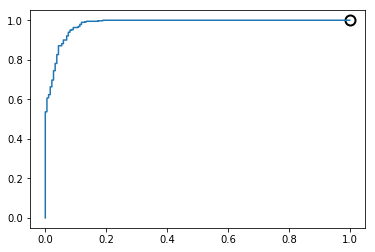

In [50]:
from sklearn.ensemble import RandomForestClassifier

grid_parms = {'n_estimators':[10, 50,100],'max_features':[2,3,4],'max_depth':[5,10,25,50,100]} 

RFC = RandomForestClassifier(random_state=123)
cv = GridSearchCV(RFC, grid_parms, cv = 5)
cv.fit(X_model_2_train,y_model_2_train)

print('Grid scores for all models based on CV:\n')
means = cv.cv_results_['mean_test_score']
stds = cv.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, cv.cv_results_['params']):
    print("%0.5f (+/-%0.05f) for %r" % (mean, std * 2, params))
    
print('\nBest parameters set found on train:', cv.best_params_)
print('\nBest model validation accuracy:', cv.best_score_)

best_model = cv.best_estimator_

y_rf = best_model.predict_proba(X_model_2_train)

fpr, tpr, thresholds = roc_curve(y_model_2_train, y_rf[:,1])
close_zero = np.argmin(np.abs(thresholds))
plt.plot(fpr[close_zero], tpr[close_zero], 'o', markersize=10, label='threshold zero', fillstyle='none', c='k', mew=2)

plt.plot(fpr, tpr, label = 'p r curve')

for row in zip(fpr, tpr, thresholds):
    print(row)  

In [55]:
prediction_rf = best_model.predict(X_model_2_test)

print(best_model.score(X_model_2_test, y_model_2_test))
print(classification_report(y_model_2_test, prediction_rf))
print(confusion_matrix(y_model_2_test, prediction_rf))

0.6743589743589744
              precision    recall  f1-score   support

         0.0       0.47      0.30      0.37       123
         1.0       0.72      0.85      0.78       267

   micro avg       0.67      0.67      0.67       390
   macro avg       0.60      0.57      0.57       390
weighted avg       0.65      0.67      0.65       390

[[ 37  86]
 [ 41 226]]


In [56]:
y_probs_test = best_model.predict_proba(X_model_2_test)
y_probs_test = pd.DataFrame(y_probs_test[:,1]).copy(deep=True)

y_probs_test['new_pred'] = (y_probs_test >= 0.6802740932182806).astype(int)
y_probs_pred_test = y_probs_test['new_pred']

print(classification_report(y_model_2_test, y_probs_pred_test))
print(confusion_matrix(y_model_2_test, y_probs_pred_test))

imp_feat = pd.DataFrame(best_model.feature_importances_).transpose()
imp_feat.columns = X_model_2_test.columns
imp_feat

              precision    recall  f1-score   support

         0.0       0.43      0.41      0.42       123
         1.0       0.73      0.75      0.74       267

   micro avg       0.64      0.64      0.64       390
   macro avg       0.58      0.58      0.58       390
weighted avg       0.64      0.64      0.64       390

[[ 50  73]
 [ 66 201]]


,probability,cashtag_tweet,financial_url,numest,char_count,word_count,word_density
0,0.837863,0.010721,0.00425,0.028635,0.035222,0.037751,0.045559


# Consider Standardizing non dummy indicator variables (probability, numest, char_count, word_count, word_density)

In [80]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_dum = X_model_2_train[['cashtag_tweet','financial_url']]
X_train_s = X_model_2_train.drop(columns=['cashtag_tweet','financial_url'])
X_train_s = pd.DataFrame(scaler.fit_transform(X_train_s), columns=['probability','numest','char_count','word_count','word_density'])
X_train_sf = pd.concat([X_train_dum.reset_index(drop=True), X_train_s.reset_index(drop=True)], axis=1)

X_test_dum = X_model_2_test[['cashtag_tweet','financial_url']]
X_test_s = X_model_2_test.drop(columns=['cashtag_tweet','financial_url'])
X_test_s = pd.DataFrame(scaler.transform(X_test_s), columns=['probability','numest','char_count','word_count','word_density'])
X_test_sf = pd.concat([X_test_dum.reset_index(drop=True), X_test_s.reset_index(drop=True)], axis=1)

Grid scores for all models based on CV:

0.89027 (+/-0.04696) for {'max_depth': 5, 'max_features': 2, 'n_estimators': 10}
0.88496 (+/-0.05817) for {'max_depth': 5, 'max_features': 2, 'n_estimators': 50}
0.88850 (+/-0.04828) for {'max_depth': 5, 'max_features': 2, 'n_estimators': 100}
0.90265 (+/-0.03713) for {'max_depth': 5, 'max_features': 3, 'n_estimators': 10}
0.89381 (+/-0.02962) for {'max_depth': 5, 'max_features': 3, 'n_estimators': 50}
0.89558 (+/-0.04098) for {'max_depth': 5, 'max_features': 3, 'n_estimators': 100}
0.90265 (+/-0.04036) for {'max_depth': 5, 'max_features': 4, 'n_estimators': 10}
0.89735 (+/-0.04277) for {'max_depth': 5, 'max_features': 4, 'n_estimators': 50}
0.89558 (+/-0.03432) for {'max_depth': 5, 'max_features': 4, 'n_estimators': 100}
0.87257 (+/-0.02876) for {'max_depth': 10, 'max_features': 2, 'n_estimators': 10}
0.89381 (+/-0.02962) for {'max_depth': 10, 'max_features': 2, 'n_estimators': 50}
0.89204 (+/-0.02601) for {'max_depth': 10, 'max_features': 2, '

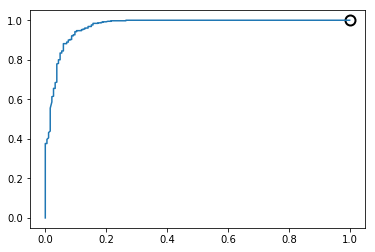

In [82]:
grid_parms = {'n_estimators':[10, 50,100],'max_features':[2,3,4],'max_depth':[5,10,25,50,100]} 

RFC = RandomForestClassifier(random_state=123)
cv = GridSearchCV(RFC, grid_parms, cv = 5)
cv.fit(X_train_sf,y_model_2_train)

print('Grid scores for all models based on CV:\n')
means = cv.cv_results_['mean_test_score']
stds = cv.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, cv.cv_results_['params']):
    print("%0.5f (+/-%0.05f) for %r" % (mean, std * 2, params))
    
print('\nBest parameters set found on train:', cv.best_params_)
print('\nBest model validation accuracy:', cv.best_score_)

best_model = cv.best_estimator_

y_rf = best_model.predict_proba(X_train_sf)

fpr, tpr, thresholds = roc_curve(y_model_2_train, y_rf[:,1])
close_zero = np.argmin(np.abs(thresholds))
plt.plot(fpr[close_zero], tpr[close_zero], 'o', markersize=10, label='threshold zero', fillstyle='none', c='k', mew=2)

plt.plot(fpr, tpr, label = 'p r curve')

for row in zip(fpr, tpr, thresholds):
    print(row)  

In [83]:
prediction_rf = best_model.predict(X_test_sf)

print(best_model.score(X_test_sf, y_model_2_test))
print(classification_report(y_model_2_test, prediction_rf))
print(confusion_matrix(y_model_2_test, prediction_rf))

0.6974358974358974
              precision    recall  f1-score   support

         0.0       0.54      0.28      0.37       123
         1.0       0.73      0.89      0.80       267

   micro avg       0.70      0.70      0.70       390
   macro avg       0.63      0.59      0.59       390
weighted avg       0.67      0.70      0.67       390

[[ 35  88]
 [ 30 237]]


In [96]:
y_probs_test = best_model.predict_proba(X_test_sf)
y_probs_test = pd.DataFrame(y_probs_test[:,1]).copy(deep=True)

y_probs_test['new_pred'] = (y_probs_test >= 0.5885004095553967).astype(int)
y_probs_pred_test = y_probs_test['new_pred']

print(classification_report(y_model_2_test, y_probs_pred_test))
print(confusion_matrix(y_model_2_test, y_probs_pred_test))

imp_feat = pd.DataFrame(best_model.feature_importances_).transpose()
imp_feat.columns = X_test_sf.columns
imp_feat

              precision    recall  f1-score   support

         0.0       0.49      0.33      0.40       123
         1.0       0.73      0.84      0.78       267

   micro avg       0.68      0.68      0.68       390
   macro avg       0.61      0.59      0.59       390
weighted avg       0.66      0.68      0.66       390

[[ 41  82]
 [ 42 225]]


,cashtag_tweet,financial_url,probability,numest,char_count,word_count,word_density
0,0.01432,0.009108,0.825036,0.03203,0.04297,0.027122,0.049413


# Try and add Twitter Sentiment from TextBlob

In [102]:
from textblob import TextBlob

TextBlob('This is an AMAZING pair of Jeans!').sentiment

Sentiment(polarity=0.7500000000000001, subjectivity=0.9)

In [112]:
X_train_snt_obj = X_train_text['clean_text'].apply(lambda row: TextBlob(row).sentiment)
X_train_text['Polarity'] = [obj.polarity for obj in X_train_snt_obj.values]
X_train_text['Subjectivity'] = [obj.subjectivity for obj in X_train_snt_obj.values]
X_train_text_snt = X_train_text.drop(columns=['clean_text'])

X_test_snt_obj = X_test_text['clean_text'].apply(lambda row: TextBlob(row).sentiment)
X_test_text['Polarity'] = [obj.polarity for obj in X_test_snt_obj.values]
X_test_text['Subjectivity'] = [obj.subjectivity for obj in X_test_snt_obj.values]
X_test_text_snt = X_test_text.drop(columns=['clean_text'])

In [121]:
X_train_meta2_s = pd.concat([X_prob_train, X_train_meta,y_train, X_train_text_snt], axis=1)
X_model_2_train_s = X_train_meta2_s.groupby(['ticker','actual_dt_e'], as_index=False).agg({'probability':'mean', 'Polarity':'mean', \
                                                                                'Subjectivity':'mean', 'cashtag_tweet':'mean', \
                                                                                'financial_url':'mean', 'numest':'max', \
                                                                                'char_count':'mean', 'word_count':'mean', \
                                                                                'word_density':'mean','eps_beat':'max'})
y_model_2_train_s = X_model_2_train_s['eps_beat']
X_model_2_train_s = X_model_2_train_s.drop(columns=['eps_beat','actual_dt_e','ticker'])


X_test_meta2_s = pd.concat([X_prob_test, X_test_meta,y_test,X_test_text_snt], axis=1)
X_model_2_test_s = X_test_meta2_s.groupby(['ticker','actual_dt_e'], as_index=False).agg({'probability':'mean', 'Polarity':'mean', \
                                                                                'Subjectivity':'mean', 'cashtag_tweet':'mean', \
                                                                                'financial_url':'mean', 'numest':'max', \
                                                                                'char_count':'mean', 'word_count':'mean', \
                                                                                'word_density':'mean','eps_beat':'max'})
y_model_2_test_s = X_model_2_test_s['eps_beat']
X_model_2_test_s = X_model_2_test_s.drop(columns=['eps_beat','actual_dt_e','ticker'])


Grid scores for all models based on CV:

0.32743 (+/-0.00000) for {'C': 0.0001, 'class_weight': 'balanced', 'max_iter': 10000, 'penalty': 'l1', 'solver': 'liblinear'}
0.67257 (+/-0.00000) for {'C': 0.0001, 'class_weight': 'balanced', 'max_iter': 10000, 'penalty': 'l1', 'solver': 'saga'}
0.53805 (+/-0.13498) for {'C': 0.0001, 'class_weight': 'balanced', 'max_iter': 10000, 'penalty': 'l2', 'solver': 'liblinear'}
0.53097 (+/-0.12615) for {'C': 0.0001, 'class_weight': 'balanced', 'max_iter': 10000, 'penalty': 'l2', 'solver': 'saga'}
0.32743 (+/-0.00000) for {'C': 0.0001, 'class_weight': None, 'max_iter': 10000, 'penalty': 'l1', 'solver': 'liblinear'}
0.67257 (+/-0.00000) for {'C': 0.0001, 'class_weight': None, 'max_iter': 10000, 'penalty': 'l1', 'solver': 'saga'}
0.67257 (+/-0.00000) for {'C': 0.0001, 'class_weight': None, 'max_iter': 10000, 'penalty': 'l2', 'solver': 'liblinear'}
0.67257 (+/-0.00000) for {'C': 0.0001, 'class_weight': None, 'max_iter': 10000, 'penalty': 'l2', 'solver': 'sa

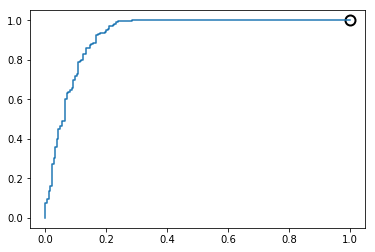

In [122]:
from sklearn.linear_model import LogisticRegression

grid_params = {'penalty':['l1','l2'], 'C':[0.0001, 0.001, 0.01, 0.1, 0.5, 0.75, 0.99, 2, 5], 'solver':['liblinear','saga'], \
              'max_iter':[10000], 'class_weight':['balanced',None]}

lr = LogisticRegression()

cv_lr = GridSearchCV(lr, grid_params, cv = 5)

cv_lr.fit(X_model_2_train_s,y_model_2_train_s)

print('Grid scores for all models based on CV:\n')
means = cv_lr.cv_results_['mean_test_score']
stds = cv_lr.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, cv_lr.cv_results_['params']):
    print("%0.5f (+/-%0.05f) for %r" % (mean, std * 2, params))
    
print('\nBest parameters set found on train:', cv_lr.best_params_)
print('\nBest model validation accuracy:', cv_lr.best_score_)

best_model = cv_lr.best_estimator_

y_lr = best_model.predict_proba(X_model_2_train_s)

fpr, tpr, thresholds = roc_curve(y_model_2_train_s, y_lr[:,1])
close_zero = np.argmin(np.abs(thresholds))
plt.plot(fpr[close_zero], tpr[close_zero], 'o', markersize=10, label='threshold zero', fillstyle='none', c='k', mew=2)

plt.plot(fpr, tpr, label = 'p r curve')

In [123]:
for row in zip(fpr, tpr, thresholds):
    print(row)  

(0.0, 0.0, 1.9923141458080396)
(0.0, 0.002631578947368421, 0.9923141458080396)
(0.0, 0.07368421052631578, 0.9757614287540389)
(0.005405405405405406, 0.07368421052631578, 0.9755074559931337)
(0.005405405405405406, 0.09736842105263158, 0.9713651439532787)
(0.010810810810810811, 0.09736842105263158, 0.9713517063760241)
(0.010810810810810811, 0.11052631578947368, 0.9699055546257783)
(0.010810810810810811, 0.11578947368421053, 0.9693562799304156)
(0.010810810810810811, 0.13421052631578947, 0.9681749259981178)
(0.016216216216216217, 0.13421052631578947, 0.9680463839718216)
(0.016216216216216217, 0.1631578947368421, 0.9648497316618855)
(0.021621621621621623, 0.1631578947368421, 0.9640308632018194)
(0.021621621621621623, 0.2710526315789474, 0.9504747757431269)
(0.02702702702702703, 0.2710526315789474, 0.9502947531711955)
(0.02702702702702703, 0.30526315789473685, 0.9465782620165913)
(0.032432432432432434, 0.30526315789473685, 0.9453656277795293)
(0.032432432432432434, 0.35789473684210527, 0.94

In [140]:
y_probs = pd.DataFrame(y_lr[:,1]).copy(deep=True)
y_probs['new_pred'] = (y_probs >= 0.52).astype(int)
y_probs_pred = y_probs['new_pred']

print(confusion_matrix(y_model_2_train_s, y_probs_pred))

[[141  44]
 [  2 378]]


In [141]:
prediction_lr = best_model.predict(X_model_2_test_s)

print(best_model.score(X_model_2_test_s, y_model_2_test_s))
print(classification_report(y_model_2_test_s, prediction_lr))
print(confusion_matrix(y_model_2_test_s, prediction_lr))
print(pd.DataFrame(best_model.coef_.tolist(),columns=X_model_2_test_s.columns))

0.6974358974358974
              precision    recall  f1-score   support

         0.0       0.53      0.32      0.40       123
         1.0       0.74      0.87      0.80       267

   micro avg       0.70      0.70      0.70       390
   macro avg       0.63      0.59      0.60       390
weighted avg       0.67      0.70      0.67       390

[[ 39  84]
 [ 34 233]]
   probability  Polarity  Subjectivity  cashtag_tweet  financial_url  \
0    17.217165 -1.071212      0.839967      -0.619774      -1.586806   

     numest  char_count  word_count  word_density  
0  0.016965    0.057242   -0.508101      -0.13777  


In [142]:
y_probs_test = best_model.predict_proba(X_model_2_test_s)
y_probs_test = pd.DataFrame(y_probs_test[:,1]).copy(deep=True)

y_probs_test['new_pred'] = (y_probs_test >= 0.52).astype(int)
y_probs_pred_test = y_probs_test['new_pred']

print(best_model.score(X_model_2_test_s, y_model_2_test_s))
print(classification_report(y_model_2_test_s, y_probs_pred_test))
print(confusion_matrix(y_model_2_test_s, y_probs_pred_test))

0.6974358974358974
              precision    recall  f1-score   support

         0.0       0.52      0.32      0.39       123
         1.0       0.73      0.87      0.79       267

   micro avg       0.69      0.69      0.69       390
   macro avg       0.63      0.59      0.59       390
weighted avg       0.67      0.69      0.67       390

[[ 39  84]
 [ 36 231]]


# Main Results Summary

Overall I would say that using just information gained from Twitter activity does not provide a large improvement over just selecting all observations as 1 (Beat EPS), as ~70% of my total observations are values of 1. I am on average able to get about 70% accuracy, with the majority of my correct predictions coming from the 'Beat EPS' observations. One potential downfall of this approach is that we do not observe the impact of not Tweeting in this sample of firm earnings announcement. In other words, it might be that a firm only tweets when they have something positive to tweet about. To further the value of this project, it would be nice to have all earnings announcements and see the impact of Twitter characteristics rather than just focusing on the earnings announcements that also have Twitter activity.

Other possible extensions include changing my analysis from averaging the probabilities of an EPS beat across each firm-announcement observations to concatenating all tweets within each firm-announcement observations and running the analysis this way. Considering the impact of the following may provide additional insights as well:
    - tfvid
    - Word2Vec
    - FastText
    - Some form of pretrained text
    - Considering the tweet text characteristics on the uncleaned text rather than the cleaned text

In [150]:
X_train_text['clean_text']

0                     pg say good start fiscal year continue top line momentum profitable market share growth
1                                                                                 report first quarter result
2               cokeceo highlight clear system vision strong brand solid execution driver quality q result jm
3          weall focus increase north america share key vertical improve performance like staffing technology
4                                                          chevron announce quarterly dividend stock dividend
5                      first quarter gaap operating profit billion gaap dilute earning per share year earlier
6                                                           polycom report fourth quarter fiscal year earning
7                                                           live webcast full year result begin ct friday jan
8                                                                                       release q fy guidance
9         

In [162]:
wpt = nltk.WordPunctTokenizer()
tokenized_corpus_train = [wpt.tokenize(document) for document in X_train_text['clean_text']]
tokenized_corpus_test = [wpt.tokenize(document) for document in X_test_text['clean_text']]

# Set values for various parameters
feature_size = 100    # Word vector dimensionality  
window_context = 30          # Context window size                                                                                    
min_word_count = 1   # Minimum word count                        
sample = 1e-3   # Downsample setting for frequent words

w2v_model = word2vec.Word2Vec(tokenized_corpus_train, size=feature_size, 
                          window=window_context, min_count=min_word_count,
                          sample=sample, iter=50)

# view similar words based on gensim's model
similar_words = {search_term: [item[0] for item in w2v_model.wv.most_similar([search_term], topn=5)]
                  for search_term in ['earning','revenue','gold','fiscal','cfo']}
similar_words

{'earning': ['fy', 'oracle', 'corp', 'conf', 'january'],
 'revenue': ['total', 'billion', 'growth', 'overall', 'dilute'],
 'gold': ['hurd', 'fda', 'boss', 'emcforum', 'felixhernandez'],
 'fiscal': ['quarter', 'fourth', 'report', 'third', 'second'],
 'cfo': ['tn', 'fun', 'amy', 'photo', 'word']}

In [159]:
def average_word_vectors(words, model, vocabulary, num_features):
    
    feature_vector = np.zeros((num_features,),dtype="float64")
    nwords = 0.
    
    for word in words:
        if word in vocabulary: 
            nwords = nwords + 1.
            feature_vector = np.add(feature_vector, model[word])
    
    if nwords:
        feature_vector = np.divide(feature_vector, nwords)
        
    return feature_vector
    
   
def averaged_word_vectorizer(corpus, model, num_features):
    vocabulary = set(model.wv.index2word)
    features = [average_word_vectors(tokenized_sentence, model, vocabulary, num_features)
                    for tokenized_sentence in corpus]
    return np.array(features)


# get document level embeddings
w2v_feature_array_train = averaged_word_vectorizer(corpus=tokenized_corpus_train, model=w2v_model,
                                             num_features=feature_size)
w2v_feature_array_test = averaged_word_vectorizer(corpus=tokenized_corpus_test, model=w2v_model,
                                             num_features=feature_size)

C:\Users\jstar\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


# to ask...

### word to vec gives a vector of each word, but we need a vector of each document...is that why we average word vectors by doc?

    - We don't do this for count_Vectorizer, so why do we do it for word2vec?
        - is it just taking the 1 number (Count_Vectorizer) and dividing it into 100 numbers?
    - word2vec has negative numbers but nmb can't deal with negative...how to fix?
    - doc2vec as simplified word2vec aggegration across doc?
   

### do we 'fit_transform' on the train and test data with word2vec or just fit_transform on train and transform on test?

In [155]:
w2v_feature_array.shape, y_train.shape

((846, 100), (846,))

C:\Users\jstar\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Grid scores for all models based on CV:

0.31678 (+/-0.00212) for {'C': 0.0001, 'class_weight': 'balanced', 'max_iter': 10000, 'penalty': 'l1', 'solver': 'liblinear'}
0.39007 (+/-0.29315) for {'C': 0.0001, 'class_weight': 'balanced', 'max_iter': 10000, 'penalty': 'l1', 'solver': 'saga'}
0.43972 (+/-0.27559) for {'C': 0.0001, 'class_weight': 'balanced', 'max_iter': 10000, 'penalty': 'l2', 'solver': 'liblinear'}
0.46927 (+/-0.07988) for {'C': 0.0001, 'class_weight': 'balanced', 'max_iter': 10000, 'penalty': 'l2', 'solver': 'saga'}
0.31678 (+/-0.00212) for {'C': 0.0001, 'class_weight': None, 'max_iter': 10000, 'penalty': 'l1', 'solver': 'liblinear'}
0.68322 (+/-0.00212) for {'C': 0.0001, 'class_weight': None, 'max_iter': 10000, 'penalty': 'l1', 'solver': 'saga'}
0.68322 (+/-0.00212) for {'C': 0.0001, 'class_weight': None, 'max_iter': 10000, 'penalty': 'l2', 'solver': 'liblinear'}
0.68322 (+/-0.00212) for {'C': 0.0001, 'class_weight': None, 'max_iter': 10000, 'penalty': 'l2', 'solver': 'sa

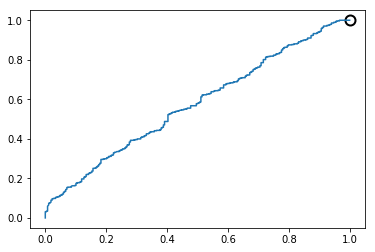

In [156]:
grid_params = {'penalty':['l1','l2'], 'C':[0.0001, 0.001, 0.01, 0.1, 0.5, 0.75, 0.99, 2, 5], 'solver':['liblinear','saga'], \
              'max_iter':[10000], 'class_weight':['balanced',None]}

lr = LogisticRegression()

cv_lr = GridSearchCV(lr, grid_params, cv = 5)

cv_lr.fit(w2v_feature_array,y_train)

print('Grid scores for all models based on CV:\n')
means = cv_lr.cv_results_['mean_test_score']
stds = cv_lr.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, cv_lr.cv_results_['params']):
    print("%0.5f (+/-%0.05f) for %r" % (mean, std * 2, params))
    
print('\nBest parameters set found on train:', cv_lr.best_params_)
print('\nBest model validation accuracy:', cv_lr.best_score_)

best_model = cv_lr.best_estimator_

y_lr = best_model.predict_proba(w2v_feature_array)

fpr, tpr, thresholds = roc_curve(y_train, y_lr[:,1])
close_zero = np.argmin(np.abs(thresholds))
plt.plot(fpr[close_zero], tpr[close_zero], 'o', markersize=10, label='threshold zero', fillstyle='none', c='k', mew=2)

plt.plot(fpr, tpr, label = 'p r curve')

# Word2Vec attempt

# What does this comment mean?

Last year, I followed Prof: Andrew Ng’s online machine learning course. His recommendation was

Training: 60%

Cross validation: 20%

Testing: 20%

# Consider a tfvid model

# Word2Vec next
# FastText? - try to approximates by ngrams


In [41]:
#####TRAIN TEST SPLIT ON ACTUAL DATA, NOT THE COUNT VECTORIZED DATA
    ####TRAIN ONLY ON THE TRAINNG DATA, MODEL SHOULD NOT KNOW THE NEW WORDS THAT APPEAR IN THE TEST DATA ONLY

In [42]:
####100 ORIGINAL OBS
#####TRAIN MODEL MNB (50%, 50/50)
    ####GET PROBABILITIES ON TEST AND TRAIN (50/50)
            ####MERGE PROB BACK INTO MODEL 1 TRAIN AND TEST DATA SETS (50/50)
                    #####RETAIN EXACT SAME SPLITS AS THE ORIGINAL MODEL TRAIN TEST SPLIT (50/50) - MODEL 2
            
#####train,test = split(df.index.values, actual labels)
    #####train_idx, test_idx - after fitting model and getting probabilities, merge back to original data and retest second
    #####stage model using same train test split sample while now including the probabilities
#####Split data first, then count vectorize each X_test, X_train separately
#####train_df = df.iloc[train_idx]
#####